In [1]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [2]:
import numpy as np
from scipy.special import softmax

def sarsa(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using SARSA.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run SARSA for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    # initialize the state-action value function and the state counts
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))
    
    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):

        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        # for each new episode, start at the given start state
        state = int(model.start_state_seq)
        # sample first action
        action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            # initialize p and r
            p, r = 0, np.random.random()
            # sample the next state according to the action and the
            # probability of the transition
            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break
            # sample the next action
            next_action = sample_action(Q, next_state, model.num_actions, epsilon, temperature, action_strategy)
            # Calculate the temporal difference and update Q function
            Q[state, action] += alpha * (model.R[state] + model.gamma * Q[next_state, next_action] - Q[state, action])
            # End episode is state is a terminal state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

            # count the state visits
            state_counts[state] += 1

            # store the previous state and action
            state = next_state
            action = next_action

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    # determine the q function and policy
    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

def sample_action(Q, state, num_actions, epsilon, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Action selection based on the specified strategy.

    Parameters
    ----------
    Q : numpy array of shape (N, num_actions)
        Q function for the environment where N is the total number of states.

    state : int
        The current state.

    num_actions : int
        The number of actions.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    action : int
        Number representing the selected action between 0 and num_actions.
    """
    if action_strategy == 'epsilon-greedy':
        if np.random.random() < epsilon:
            action = np.random.randint(0, num_actions)
        else:
            action = np.argmax(Q[state, :])
    elif action_strategy == 'softmax':
        action_values = Q[state, :]
        probabilities = softmax(action_values / temperature)
        action = np.random.choice(np.arange(num_actions), p=probabilities)
    else:
        raise ValueError("Invalid action_strategy. Use 'epsilon-greedy' or 'softmax'.")

    return action


def qlearning(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using Q-learning.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run Q-learning for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))

    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):
        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        state = int(model.start_state_seq)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)

            p, r = 0, np.random.random()

            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break

            Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])

            state_counts[state] += 1

            state = next_state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

In [3]:
from plots import plot_gridworld

In [4]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1.0,
                              bias=0.5)

env_0 = gw.create_gridworld()


In [5]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_0, alpha=0.1, epsilon=0.2, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [6]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


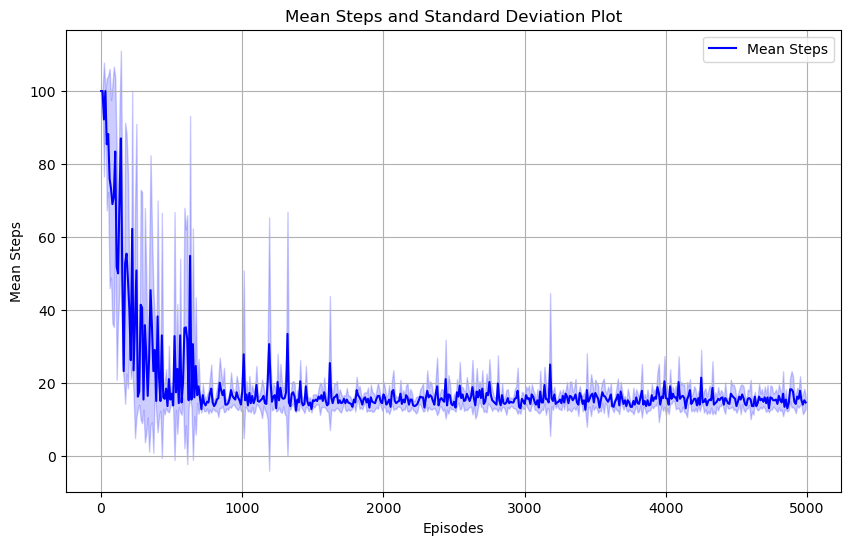

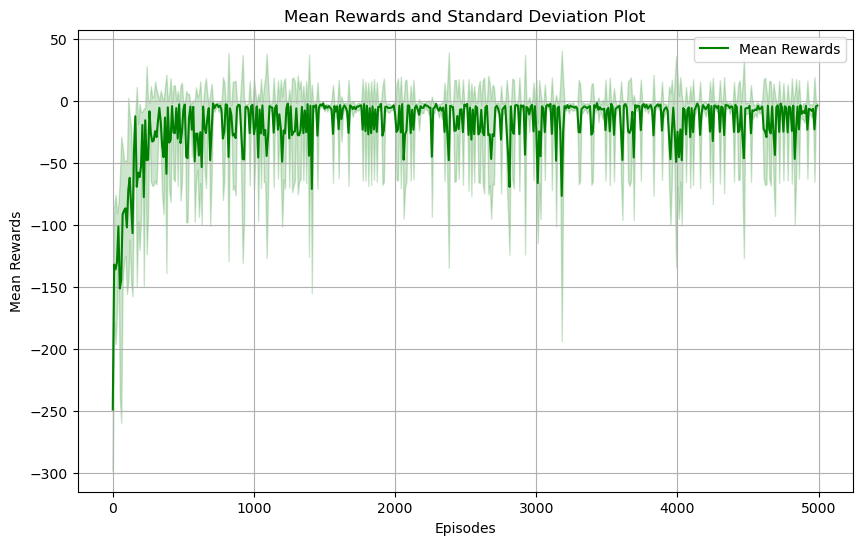

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


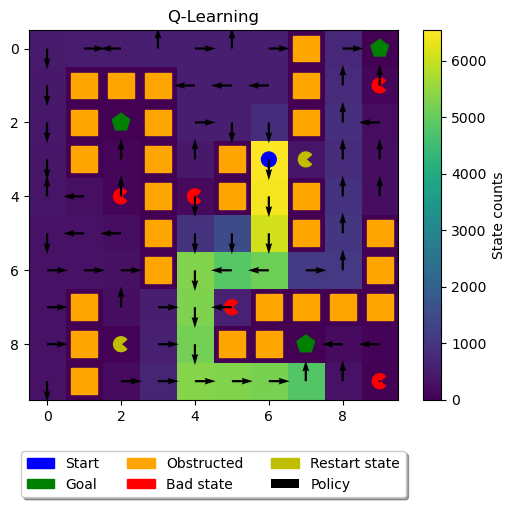

In [8]:

plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="Q-Learning")

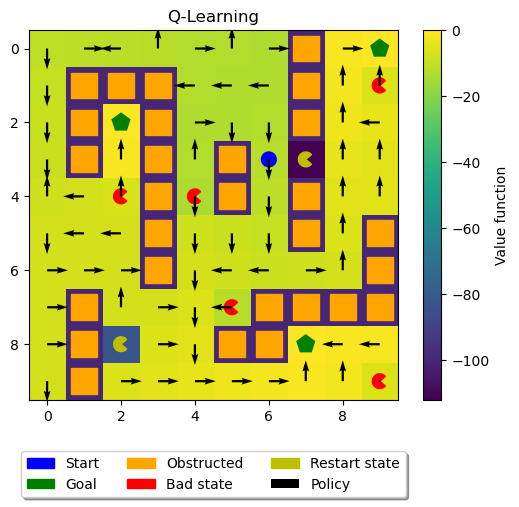

In [9]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="Q-Learning")

In [10]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_0, alpha=0.1, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=1.0)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [11]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


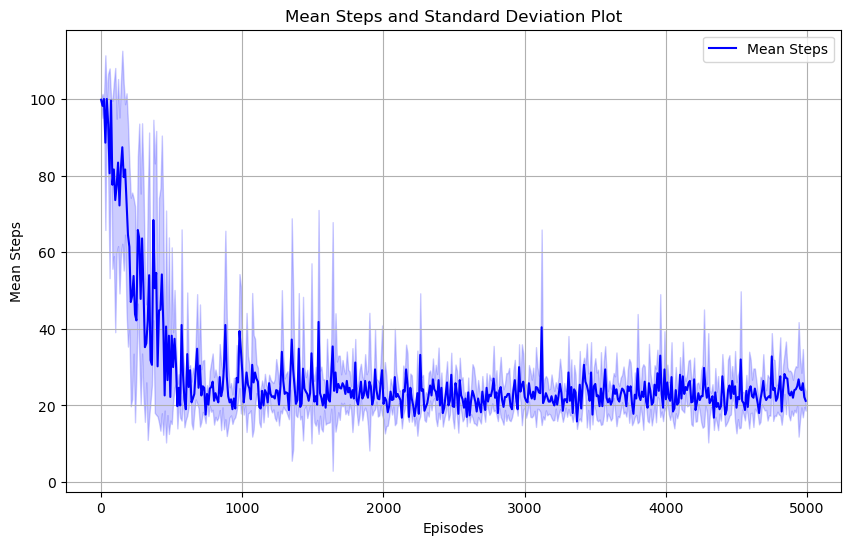

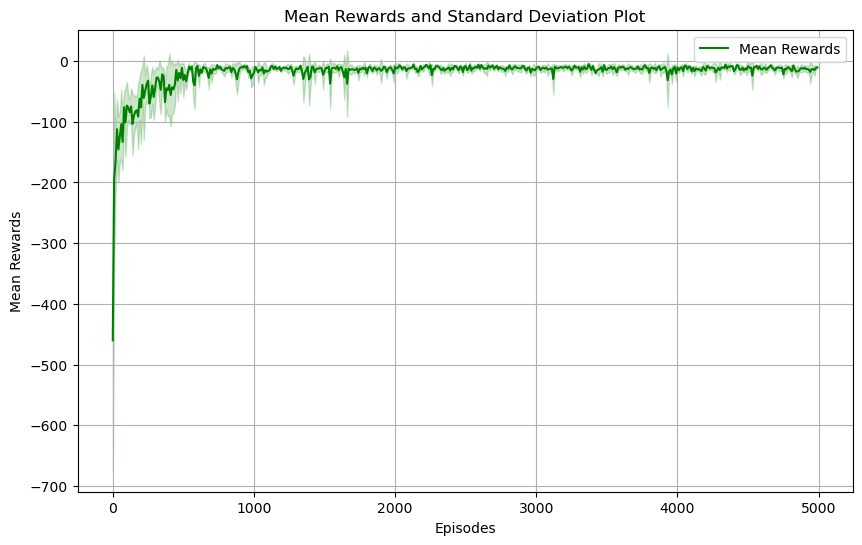

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


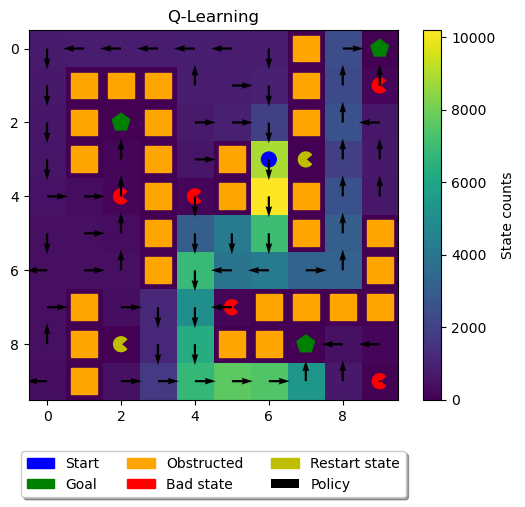

In [13]:

plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="Q-Learning")

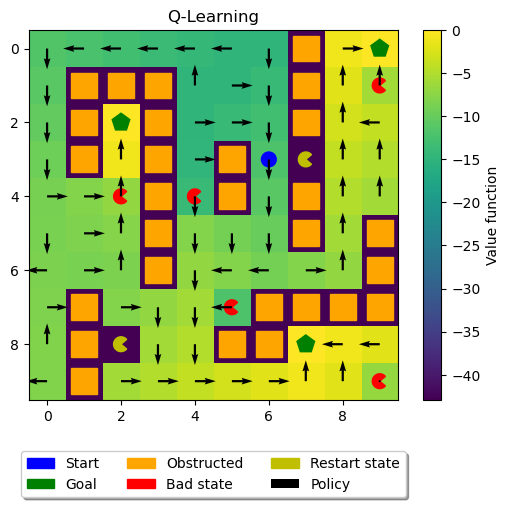

In [14]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="Q-Learning")

In [15]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1.0,
                              bias=0.5)

env_1 = gw.create_gridworld()


In [16]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_1, alpha=0.1, epsilon=0.2, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [17]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


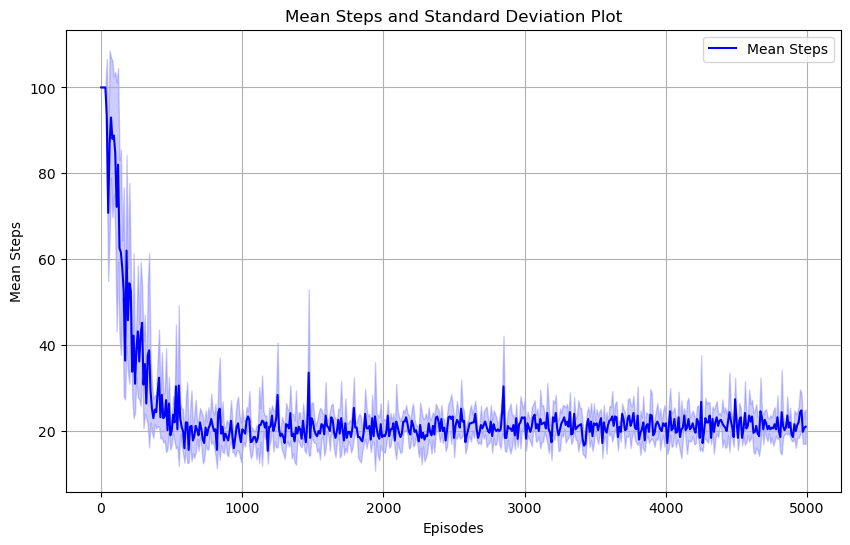

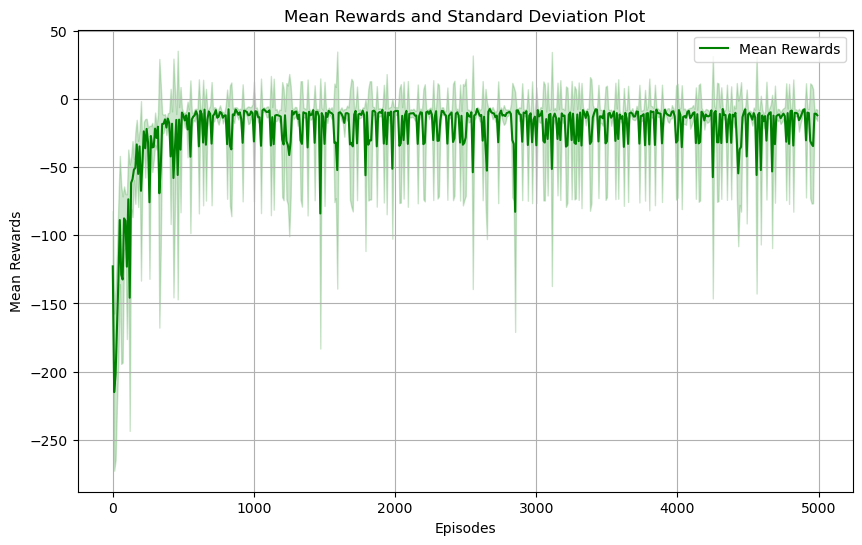

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


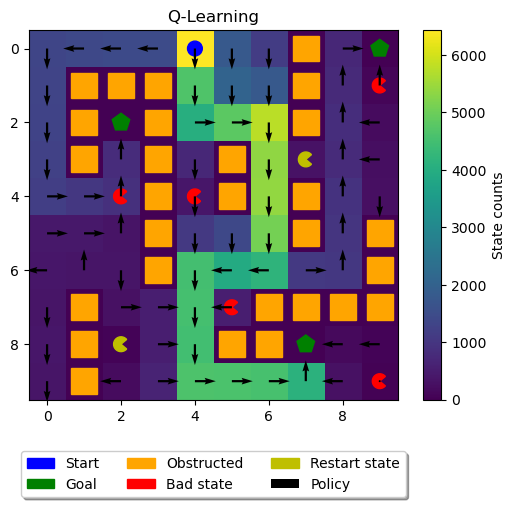

In [19]:

plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="Q-Learning")

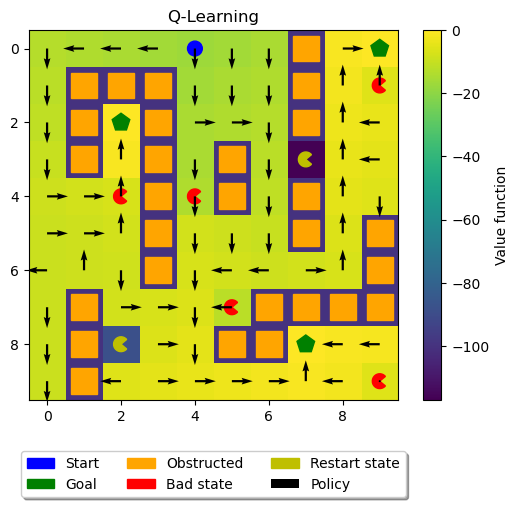

In [20]:

plot_gridworld(env_1, policy=pi,value_function=avg_q, title="Q-Learning")

In [21]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_1, alpha=0.1, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=1.0)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [22]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


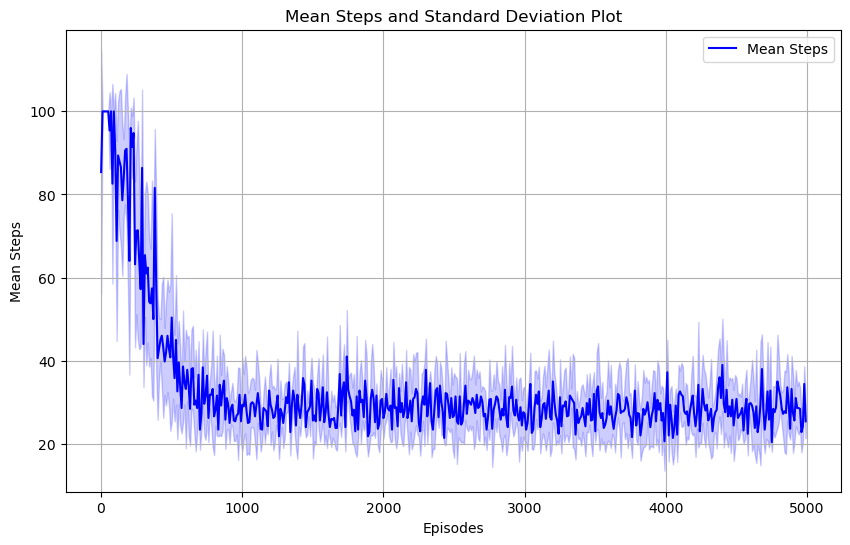

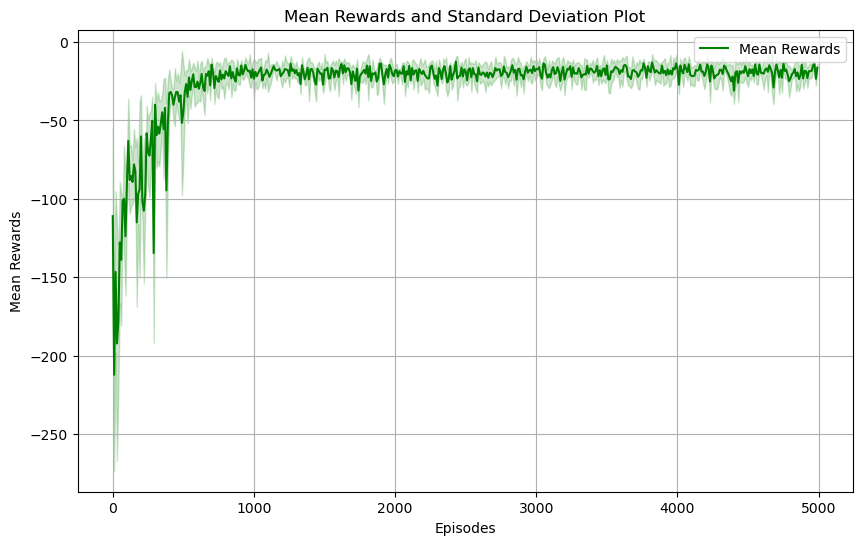

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


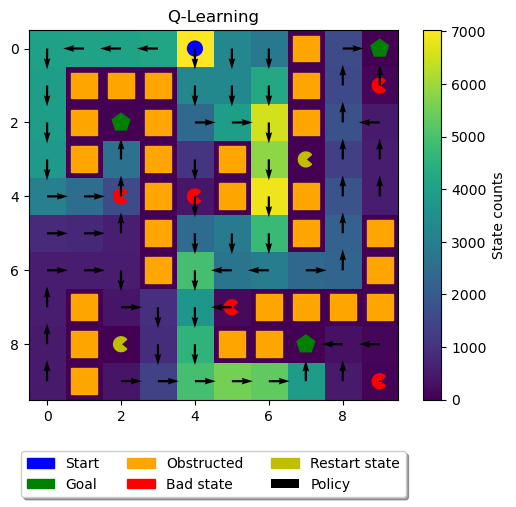

In [24]:

plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="Q-Learning")

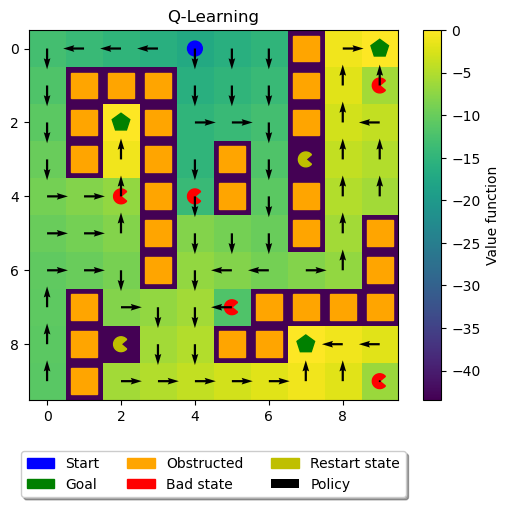

In [25]:
plot_gridworld(env_1, policy=pi,value_function=avg_q, title="Q-Learning")